# Train Script
This is the training script run in Colab for training the BERT models. It consists of 2 training methods. One old which was generating 5-7 questions per review and one new which is using [GPL](https://github.com/UKPLab/gpl) to generate and train a model.

## Info and setup
Info about which GPU and how much RAM it has, as well as installation of dependencies

In [ ]:
gpu_info = !nvidia-smi -L
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Select the Runtime > "Change runtime type" menu to enable a GPU accelerator, ')
  print('and then re-execute this cell.')
else:
  print(gpu_info)

GPU 0: Tesla P100-PCIE-16GB (UUID: GPU-7e4501a2-b639-aef0-e2ae-3a2a4e2ceeb9)


In [ ]:
from psutil import virtual_memory
ram_gb = virtual_memory().total / 1e9
print('Your runtime has {:.1f} gigabytes of available RAM\n'.format(ram_gb))

if ram_gb < 20:
  print('To enable a high-RAM runtime, select the Runtime > "Change runtime type"')
  print('menu, and then select High-RAM in the Runtime shape dropdown. Then, ')
  print('re-execute this cell.')
else:
  print('You are using a high-RAM runtime!')

Your runtime has 13.6 gigabytes of available RAM

To enable a high-RAM runtime, select the Runtime > "Change runtime type"
menu, and then select High-RAM in the Runtime shape dropdown. Then, 
re-execute this cell.


In [ ]:
!pip install sentence-transformers gpl faiss-gpu

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 85 kB 3.2 MB/s 
     |████████████████████████████████| 85.5 MB 108 kB/s 
     |████████████████████████████████| 4.9 MB 41.1 MB/s 
     |████████████████████████████████| 1.3 MB 48.7 MB/s 
     |████████████████████████████████| 120 kB 53.0 MB/s 
     |████████████████████████████████| 6.6 MB 60.6 MB/s 
     |████████████████████████████████| 50 kB 7.2 MB/s 
     |████████████████████████████████| 339 kB 61.1 MB/s 
     |████████████████████████████████| 8.6 MB 54.8 MB/s 
     |████████████████████████████████| 64 kB 3.0 MB/s 
     |████████████████████████████████| 52 kB 1.9 MB/s 
     |████████████████████████████████| 5.9 MB 30.9 MB/s 
     |████████████████████████████████| 578.0 MB 16 kB/s 
INFO: pip is looking at multiple versions of tensorflow-text to determine which version is compatible with other requirements. This could take a while.
   

In [ ]:
# Connect to google drive 
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


## Training with GPL
Command to train using GPL

In [ ]:
!python -m gpl.train --help

2022-08-21 12:59:08 - Loading faiss with AVX2 support.
2022-08-21 12:59:08 - Could not load library with AVX2 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")
2022-08-21 12:59:08 - Loading faiss.
2022-08-21 12:59:08 - Successfully loaded faiss.
/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'gpl.train' found in sys.modules after import of package 'gpl', but prior to execution of 'gpl.train'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
usage: train.py [-h] --path_to_generated_data PATH_TO_GENERATED_DATA
                --output_dir OUTPUT_DIR [--do_evaluation]
                [--evaluation_data EVALUATION_DATA]
                [--evaluation_output EVALUATION_OUTPUT]
                [--qgen_prefix QGEN_PREFIX] [--base_ckpt BASE_CKPT]
                [--generator GENERATOR] [--cross_encoder CROSS_ENCODER]
                [--batch_size_gpl BATCH_SIZE_GPL]
                [--batch_size_generation BATCH_SIZE_GENERATION]
              

In [ ]:
!python -m gpl.train --path_to_generated_data "/content/drive/My Drive/generated_v5" --output_dir "/content/drive/My Drive/anirec-model-v1" --base_ckpt "sebastian-hofstaetter/distilbert-dot-tas_b-b256-msmarco" \
    --gpl_score_function "dot" \
    --batch_size_gpl 32 \
    --gpl_steps 15_000 \
    --queries_per_passage -1 \
    --new_size -1 \
    --generator="BeIR/query-gen-msmarco-t5-base-v1" \
    --cross_encoder="cross-encoder/ms-marco-MiniLM-L-6-v2" \
    --retrievers "msmarco-distilbert-base-v4" "msmarco-MiniLM-L-6-v3" \
    --retriever_score_functions "cos_sim" "cos_sim" \
    --qgen_prefix="qgen" \
    --use_amp

2022-09-16 11:08:44 - Loading faiss with AVX2 support.
2022-09-16 11:08:44 - Could not load library with AVX2 support due to:
ModuleNotFoundError("No module named 'faiss.swigfaiss_avx2'")
2022-09-16 11:08:44 - Loading faiss.
2022-09-16 11:08:44 - Successfully loaded faiss.
/usr/lib/python3.7/runpy.py:125: RuntimeWarning: 'gpl.train' found in sys.modules after import of package 'gpl', but prior to execution of 'gpl.train'; this may result in unpredictable behaviour
  warn(RuntimeWarning(msg))
[2022-09-16 11:08:46] INFO [gpl.train.train:79] Corpus does not exist in /content/drive/My Drive/generated_v5. Now clone the one from the evaluation path None
Traceback (most recent call last):
  File "/usr/lib/python3.7/runpy.py", line 193, in _run_module_as_main
    "__main__", mod_spec)
  File "/usr/lib/python3.7/runpy.py", line 85, in _run_code
    exec(code, run_globals)
  File "/usr/local/lib/python3.7/dist-packages/gpl/train.py", line 250, in <module>
    train(**vars(args))
  File "/usr/loc

## Utility functions
For loading dataset, models etc.
Some of it got used and some of it was thrown away, but kept for post dexterity

In [ ]:
# Import the necessary packages
import numpy as np
import matplotlib.pyplot as plt
import csv
import pickle
import pandas as pd
import numpy as np
from transformers import GPT2TokenizerFast
from sentence_transformers import SentenceTransformer, util
import os
import pickle

The cache for model files in Transformers v4.22.0 has been updated. Migrating your old cache. This is a one-time only operation. You can interrupt this and resume the migration later on by calling `transformers.utils.move_cache()`.


Moving 0 files to the new cache system


0it [00:00, ?it/s]

In [ ]:
def load_model():
    return SentenceTransformer('msmarco-distilbert-base-tas-b')


def load_dataset(path):
    """
    Loads the dataset from the given path.
    """   
    df = pd.read_csv(path)

    #df['search'] = df['search'].astype(list)

    print(f"Dataset length: {len(df)}")


    return df

In [ ]:
df = load_dataset("/content/drive/My Drive/all_reviews_full_IT.csv")

Dataset length: 106661


Check how long reviews are on average

/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


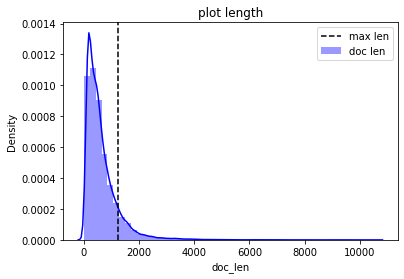

Average length of tokens in the reviews: 639.536676063096


In [ ]:
import seaborn as sns

df['doc_len'] = df['Review'].apply(lambda words: len(words.split()))
max_seq_len = np.round(df['doc_len'].mean() + df['doc_len'].std()).astype(int)
sns.distplot(df['doc_len'], hist=True, kde=True, color='b', label='doc len')
plt.axvline(x=max_seq_len, color='k', linestyle='--', label='max len')
plt.title('plot length'); plt.legend()
plt.show()

print(f"Average length of tokens in the reviews: {df['doc_len'].mean()}")

In [ ]:
df = pd.read_csv('/content/drive/My Drive/all_interest_stacks.csv')
# Print the longest, shortest and average length of 'Review' column
print(f"Longest review: {df['Review'].str.len().max()}")
print(f"Shortest review: {df['Review'].str.len().min()}")
print(f"Average review length: {df['Review'].str.len().mean()}")
df = df[df['Review'].str.len() > 300]
print(f"Longest review: {df['Review'].str.len().max()}")
print(f"Shortest review: {df['Review'].str.len().min()}")
print(f"Average review length: {df['Review'].str.len().mean()}")
print(f"Length of dataset: {len(df)}")
df.to_csv('/content/drive/My Drive/all_interest_stacks_trimmed.csv', index=False)

Longest review: 10061
Shortest review: 3
Average review length: 297.09856643480106
Longest review: 10061
Shortest review: 301
Average review length: 745.2140001230239
Length of dataset: 16257


## Initial method used to generate query for reviews
Using a doc2query model

In [ ]:
from transformers import T5Tokenizer, T5ForConditionalGeneration
import torch
model_name = 'doc2query/all-with_prefix-t5-base-v1' # BeIR/query-gen-msmarco-t5-large-v1 | doc2query/all-with_prefix-t5-base-v1
tokenizer = T5Tokenizer.from_pretrained(model_name)
model = T5ForConditionalGeneration.from_pretrained(model_name)
#model.eval()

In [ ]:
#Select the device
device = 'cuda'
model.to(device)
print("Went to device")

Went to device


In [ ]:
# Parameters for generation
batch_size = 8 #Batch size
num_queries = 10 #Number of queries to generate for every paragraph
max_length_paragraph = 2048 #Max length for paragraph
max_length_query = 128   #Max length for output query

## If I'm going to do it again, increase the batch size and max length etc.
# Parameters for generation
#batch_size = 64 #Batch size
#num_queries = 5 #Number of queries to generate for every paragraph
#max_length_paragraph = 2048 #Max length for paragraph
#ax_length_query = 128   #Max length for output query

In [ ]:
def _removeNonAscii(s): return "".join(i for i in s if ord(i) < 128)

In [ ]:
from tqdm import tqdm

paragraphs = df['Review'].tolist()
prefix = 'answer2question'

with open('generated_queries_all.tsv', 'w') as fOut:
    for start_idx in tqdm(range(0, len(paragraphs), batch_size)):
        sub_paragraphs = paragraphs[start_idx:start_idx+batch_size]
        sub_paragraphs = [prefix + ': ' + paragraph for paragraph in sub_paragraphs]
        inputs = tokenizer.prepare_seq2seq_batch(sub_paragraphs, max_length=max_length_paragraph, truncation=True, return_tensors='pt').to(device)
        outputs = model.generate(
            **inputs,
            max_length=max_length_query,
            do_sample=True,
            top_p=0.95,
            num_return_sequences=num_queries)

        for idx, out in enumerate(outputs):
            query = tokenizer.decode(out, skip_special_tokens=True)
            query = _removeNonAscii(query)
            para = sub_paragraphs[int(idx/num_queries)]
            para = _removeNonAscii(para)
            fOut.write("{}\t{}\n".format(query.replace("\t", " ").strip(), para.replace("\t", " ").strip()))

  0%|          | 0/6253 [00:00<?, ?it/s]/usr/local/lib/python3.7/dist-packages/transformers/tokenization_utils_base.py:3579: FutureWarning: 
`prepare_seq2seq_batch` is deprecated and will be removed in version 5 of HuggingFace Transformers. Use the regular
`__call__` method to prepare your inputs and the tokenizer under the `as_target_tokenizer` context manager to prepare
your targets.

Here is a short example:

model_inputs = tokenizer(src_texts, ...)
with tokenizer.as_target_tokenizer():
    labels = tokenizer(tgt_texts, ...)
model_inputs["labels"] = labels["input_ids"]

See the documentation of your specific tokenizer for more details on the specific arguments to the tokenizer of choice.
For a more complete example, see the implementation of `prepare_seq2seq_batch`.

  warnings.warn(formatted_warning, FutureWarning)
100%|██████████| 6253/6253 [10:18:56<00:00,  5.94s/it]


In [ ]:
import shutil

shutil.move("generated_queries_all.tsv", "/content/drive/My Drive/generated_queries_all.tsv")

'/content/drive/My Drive/generated_queries_all.tsv'

In [ ]:
from sentence_transformers import SentenceTransformer, InputExample, losses, models, datasets
from torch import nn
import os
import random

train_examples = [] 
with open('/content/drive/My Drive/generated_queries_all.tsv') as fIn:
    for line in fIn:
        try:
            query, paragraph = line.strip().split('\t', maxsplit=1)
            train_examples.append(InputExample(texts=[query, paragraph]))
        except:
            pass
        
random.shuffle(train_examples)

BATCH_SIZE=32

# For the MultipleNegativesRankingLoss, it is important
# that the batch does not contain duplicate entries, i.e.
# no two equal queries and no two equal paragraphs.
# To ensure this, we use a special data loader
train_dataloader = datasets.NoDuplicatesDataLoader(train_examples, batch_size=BATCH_SIZE)

# Now we create a SentenceTransformer model from scratch
word_emb = models.Transformer('sebastian-hofstaetter/distilbert-dot-tas_b-b256-msmarco')
pooling = models.Pooling(word_emb.get_word_embedding_dimension())
model = SentenceTransformer(modules=[word_emb, pooling])

print("Max Sequence Length:", model.max_seq_length)
model.max_seq_length = 512
print("New Max Sequence Length:", model.max_seq_length)

model.to("cuda")


# MultipleNegativesRankingLoss requires input pairs (query, relevant_passage)
# and trains the model so that is is suitable for semantic search
train_loss = losses.MultipleNegativesRankingLoss(model)


#Tune the model
num_epochs = 5
warmup_steps = int(len(train_dataloader) * num_epochs * 0.1)
model.fit(train_objectives=[(train_dataloader, train_loss)], epochs=num_epochs, warmup_steps=warmup_steps, show_progress_bar=True,
          checkpoint_path='/content/drive/My Drive/search-model-v7-checkpoints',
          checkpoint_save_steps=10_000)

#os.makedirs('search', exist_ok=True)
model.save('/content/drive/My Drive/search-model-v7')

Max Sequence Length: 512
New Max Sequence Length: 512


Epoch:   0%|          | 0/5 [00:00<?, ?it/s]

Iteration:   0%|          | 0/15630 [00:00<?, ?it/s]

Iteration:   0%|          | 0/15630 [00:00<?, ?it/s]

Iteration:   0%|          | 0/15630 [00:00<?, ?it/s]

Iteration:   0%|          | 0/15630 [00:00<?, ?it/s]

Iteration:   0%|          | 0/15630 [00:00<?, ?it/s]

## Get the embeddings
Either as a .csv file, pickle file, or a faiss index file.

In [ ]:
df = load_dataset("/content/drive/My Drive/all_reviews_full_plus.csv")

Dataset length: 163687


In [ ]:
model = SentenceTransformer('/content/drive/My Drive/anirec-model-v1')

In [ ]:
print("Max Sequence Length:", model.max_seq_length)
model.max_seq_length = 512
print("New Max Sequence Length:", model.max_seq_length)

Max Sequence Length: 512
New Max Sequence Length: 512


In [ ]:
import faiss
encoded_data = model.encode(df['Review'].tolist())
encoded_data = np.asarray(encoded_data.astype('float32'))
index = faiss.IndexIDMap(faiss.IndexFlatIP(768))
index.add_with_ids(encoded_data, np.array(range(0, len(df))))
faiss.write_index(index, 'anime_reviews-search-model-v3-L.index')

In [ ]:
import shutil

shutil.move("anime_reviews-search-model-v3-L.index", "/content/drive/My Drive/anime-reviews-anirec-model-v1.index")

'/content/drive/My Drive/anime-reviews-anirec-model-v1.index'